In [9]:
# das bringt nix.
# man weiß ja ned vorher wie stark der induzierte phenotype sein wird, also is das hier für die tonne.

Essential questions:
- How many cells should be recommended per perturbation?
- Does this number depend on the type of perturbation and how?

Methods:
- subsample cells, then train classifier
- record classifier performance across subsamplings as a sequence per perturbation
- compare these sequences

In [1]:
import subprocess
import os
import sys
import matplotlib.backends.backend_pdf
import scanpy as sc
import matplotlib.pyplot as pl
import anndata as ad
import pandas as pd
import numpy as np
import scvelo as scv
scv.settings.verbosity=1

# Jupyter stuff
from tqdm.notebook import tqdm
from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline

# Custom functions
sys.path.insert(1, '../..')
from utils import *

In [2]:
# paths
at_home = False if '/fast/work/users/' in os.getcwd() else True
data_path = '/extra/stefan/data/perturbation_resource_paper/' if at_home else '/fast/work/users/peidlis_c/data/perturbation_resource_paper/'
signatures_path = '/home/peidli/utils/scrnaseq_signature_collection/' if at_home else '/fast/work/users/peidlis_c/utils/scrnaseq_signature_collection/'
utils_path = '/extra/stefan/utils/scrnaseq_utils/' if at_home else '/fast/work/users/peidlis_c/utils/single_cell_rna_seq/scrnaseq_utils/'

# Stefan's utils
sys.path.insert(1, utils_path)
from scrnaseq_util_functions import *

In [3]:
h5_files = {}
for path, subdirs, files in os.walk(data_path):
    for name in files:
        if '.h5' in name: h5_files[name[:-3]] = os.path.join(path, name)
del h5_files['exampledataset']
del h5_files['NormanWeissman2019_raw']
del h5_files['PapalexiSatija2021_eccite_arrayed_protein']
del h5_files['PapalexiSatija2021_eccite_protein']
del h5_files['FrangiehIzar2021_protein']
print(len(h5_files))
list(h5_files.keys())

39


['PapalexiSatija2021_eccite_arrayed_RNA',
 'PapalexiSatija2021_eccite_RNA',
 'TianKampmann2021_CRISPRa',
 'TianKampmann2021_CRISPRi',
 'XieHon2017',
 'AissaBenevolenskaya2021',
 'McFarlandTshemiak2020_all_expts_combined',
 'GasperiniShendure2019_lowMOI',
 'GasperiniShendure2019_atscale',
 'GasperiniShendure2019_highMOI',
 'ZhaoSims2021',
 'DixitRegev2016',
 'DatlingerBock2017',
 'DatlingerBock2021',
 'FrangiehIzar2021_RNA',
 'WeinrebKlein2020',
 'ShifrutMarson2018',
 'ReplogleWeissman2022_K562_essential',
 'ReplogleWeissman2022_K562_gwps',
 'ReplogleWeissman2022_rpe1',
 'ChangYe2021',
 'gene_scores',
 'peak_bc',
 'ChromVar',
 'LSI_embedding',
 'markerpeak_target',
 'SchiebingerLander2019_GSE115943',
 'SchiebingerLander2019_GSE106340',
 'NormanWeissman2019_filtered',
 'SchraivogelSteinmetz2020_TAP_SCREEN__chromosome_11_screen',
 'SchraivogelSteinmetz2020_TAP_SCREEN__chromosome_8_screen',
 'AdamsonWeissman2016_GSM2406677_10X005',
 'AdamsonWeissman2016_GSM2406681_10X010',
 'AdamsonWeissma

In [4]:
key = 'ZhaoSims2021'
SDIR = "/fast/scratch/users/peidlis_c/perturbation_resource_paper/"
adata = sc.read(SDIR+'tmp_data_' + key + '.h5')

# Subsample counts

In [5]:
key = 'ZhaoSims2021'
SDIR = "/fast/scratch/users/peidlis_c/perturbation_resource_paper/"
adata = sc.read(SDIR+'tmp_data_' + key + '.h5')

# normalize simply
adata.X = adata.layers['counts'].copy()  # reset X
ncounts = rsum(adata.X, 1)
adata.X = np.median(ncounts) * adata.layers['counts'] / ncounts[:, np.newaxis]
sc.pp.log1p(adata)
n_var_max = 2000  # max total features to select
sc.pp.highly_variable_genes(adata, n_top_genes=n_var_max, subset=False, flavor='seurat_v3', layer='counts')
sc.pp.pca(adata, use_highly_variable=True)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

In [6]:
# we must not filter
# therefore we must normalize by original size factors
def pp(adata, ncounts):
    adata.layers['counts'] = adata.X.copy()
    adata.X = np.median(ncounts) * adata.layers['counts'] / ncounts[:, np.newaxis]
    sc.pp.log1p(adata)
    n_var_max = 2000  # max total features to select
    sc.pp.highly_variable_genes(adata, n_top_genes=n_var_max, subset=False, flavor='seurat_v3', layer='counts')
    sc.pp.pca(adata, use_highly_variable=True)
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)
    return adata

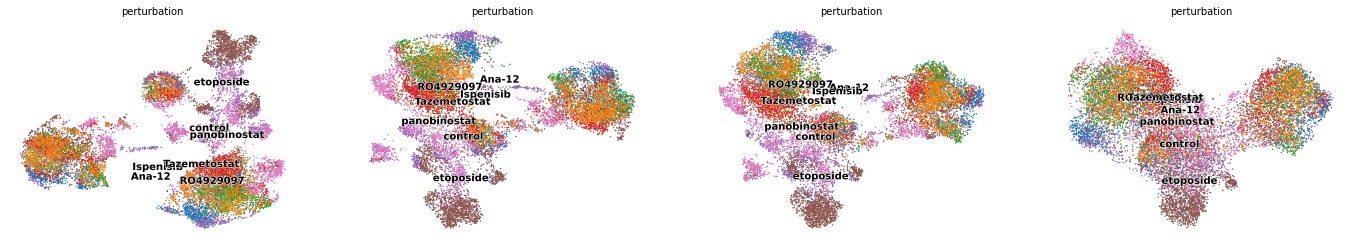

In [7]:
fig, axs = pl.subplots(1, 4, figsize=[6*4,4])
tab = pd.DataFrame(index=pd.unique(adata.obs.perturbation))

ps = [1, 0.8, 0.5, 0.1]
for i, p in enumerate(ps):
    if p==1:
        bdata = adata.copy()
    else:
        # subsample counts
        bdata = adata.copy()
        bdata.X = adata.layers['counts'].copy()  # reset X
        total_counts = int(np.sum(bdata.X) * p)
        sc.pp.downsample_counts(bdata, total_counts=total_counts)
        bdata.X[pd.isna(bdata.X)]=0
        bdata = pp(bdata, ncounts)
        
    scv.pl.scatter(bdata, color='perturbation', ax=axs[i], show=False)

    conf_mat, classes = simple_classifier_confusion(adata, 'X_pca', 'perturbation', propagate='test', symmetrize=False, col_normalize=False, cluster=False)
    accuracies_per_class = np.diag(conf_mat / np.sum(conf_mat, axis=1))
    tab[str(p)] = accuracies_per_class
pl.show()

In [11]:
(bdata.X<0).sum()

0

In [10]:
pd.isna(bdata.X).sum()

0

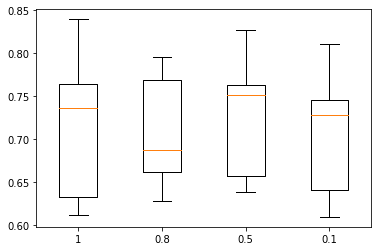

In [8]:
pl.boxplot([tab[str(p)] for p in ps])
pl.xticks([1,2,3,4], ps)
pl.show()

# Subsample cells

## Single iteration per node per group

In [8]:
conf_tensor, classes, ratios = simple_classifier_confusion(adata, 'X_pca', 'perturbation', test_size_fraction=0.2, n_nodes=20, method='SVC')

Note: a node is a ratio of subsampling. e.g. node number 0 corresponds to idk subsampling of just 20%.

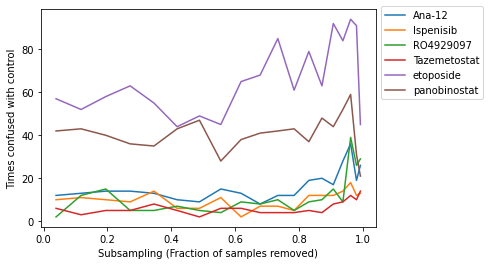

In [9]:
control_i = np.where(classes=='control')[0][0]
for i, x in enumerate(classes):
    if x=='control': continue
    X = conf_tensor[:, i, control_i]
    mask = ~pd.isna(X)
    pl.plot(np.array(ratios)[mask], X[mask], label=x)
pl.xlabel('Subsampling (Fraction of samples removed)')
pl.ylabel('Times confused with control')
# Put a legend to the right of the current axis
pl.legend(loc='center left', bbox_to_anchor=(1, 0.8))
# pl.yscale('log')
pl.show()

## Multiple iterations per node per group

In [13]:
confs = []
W = 5  # iterations per node per classifier
test_size_fraction = 0.2
for w in tqdm(np.arange(W)):
    conf_tensor, classes, ratios = simple_classifier_confusion(adata, 'X_pca', 'perturbation', test_size_fraction=test_size_fraction, n_nodes=20, method='SVC')
    confs.append(conf_tensor)
    clear_output()

100%|██████████| 5/5 [04:21<00:00, 52.30s/it]


In [14]:
tensor_ = np.array(confs)

In [18]:
tensor = np.mean(tensor_, axis=0)
std = np.std(tensor_, axis=0)

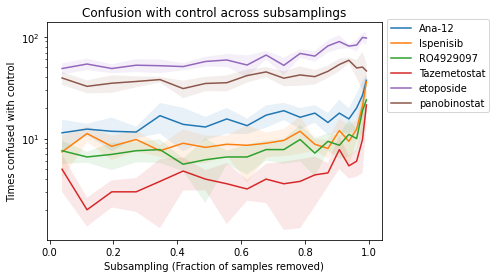

In [19]:
control_i = np.where(classes=='control')[0][0]
for i, x in enumerate(classes):
    if x=='control': continue
    Y = tensor[:, i, control_i]
    X = np.array(ratios)
    yerr = std[:, i, control_i]
    # pl.errorbar(X, Y, yerr=yerr, label=x, capsize=4, capthick=2)
    pl.plot(X, Y, label=x)
    pl.fill_between(X, Y+yerr, Y-yerr, alpha=0.1)
pl.xlabel('Subsampling (Fraction of samples removed)')
pl.ylabel('Times confused with control')
pl.title('Confusion with control across subsamplings')
pl.yscale('log')

# Put a legend to the right of the current axis
pl.legend(loc='center left', bbox_to_anchor=(1, 0.8))
pl.show()

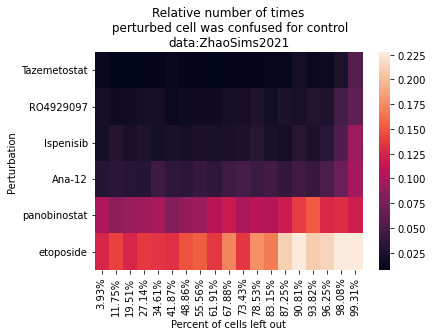

In [27]:
N = adata.obs['perturbation'].value_counts()[0]
n_tests = test_size_fraction * N  # number of test cells per group
Z = tensor[:, :, control_i]
idx_not_control = [x for x in range(len(classes)) if x!=control_i]
Z = Z[:, idx_not_control].T
df = pd.DataFrame(Z, index=classes[idx_not_control], columns=[f'{x}%' for x in np.round(ratios*100, 2)])
order = np.argsort(np.mean(df, axis=1).values)
df = df.iloc[order] / n_tests
sns.heatmap(df, robust=True)
pl.xlabel('Percent of cells left out')
pl.ylabel('Perturbation')
pl.title(f'Relative number of times\n perturbed cell was confused for control\ndata:{name}')
pl.show()

# DEPRECATED: Number of DE genes as metric

Not a good idea, testing methods not reliable enough (ttest vs wald vs lrt).

In [267]:
name = 'ZhaoSims2021'
adata = read_from_singles(f'{data_path}{name}')

In [268]:
sc.pp.filter_cells(adata, min_counts=1000)
sc.pp.normalize_per_cell(adata)
sc.pp.filter_genes(adata, min_cells=50)
sc.pp.log1p(adata)

In [269]:
counts_per_group = adata.obs.perturbation.value_counts()
counts_per_group

control         62514
etoposide       29410
panobinostat    15657
Ana-12           4360
RO4929097        3775
Tazemetostat     2599
Ispenisib        1935
Name: perturbation, dtype: int64

In [270]:
len(counts_per_group)

7

In [271]:
# make perturbations same size by subsampling to smallest acceptable size
N = np.min(counts_per_group)  # min number of cells for a perturbation to be considered
N = int(np.median(counts_per_group)) if N < 50 else N
groups = [x for x in pd.unique(adata.obs.perturbation) if counts_per_group[x] > N]
selection = np.ravel(np.array([np.random.choice(adata.obs_names[adata.obs.perturbation==p], size=N, replace=False) for p in groups]))
adata = adata[selection].copy()

In [272]:
adata.obs.perturbation.value_counts()

Ana-12          1935
RO4929097       1935
Tazemetostat    1935
control         1935
etoposide       1935
panobinostat    1935
Name: perturbation, dtype: int64

In [273]:
test_size_fraction = 0.2
M = 30  # number of nodes
min_ratio = (1+test_size_fraction) * len(groups) / N  # equals one cell per group
ratios = np.array([np.cos(np.pi * (2*k-1) / (4*M)) for k in np.arange(M, 0, -1)])  # positive side of chebyshev nodes
ratios = ratios[ratios<(1-min_ratio)]

In [274]:
sc.tl.rank_genes_groups(adata, groupby='perturbation', reference='control')

In [276]:
DEG_dict = get_DEGs(adata)

In [323]:
h = []
for key in DEG_dict:
    df = DEG_dict[key]
    hits = np.sum((df.pvals_adj > 0.05) & (np.abs(df.logfoldchanges) > 2))
    h.append(hits)

In [324]:
h    

[8445, 8351, 8498, 8890, 8660]

In [326]:
hs = []
for subsampling_removal in tqdm(ratios, leave=False):
    from sklearn.model_selection import train_test_split
    non_control = adata.obs.perturbation!='control'
    y = list(adata.obs.perturbation[non_control])  # labels
    obs_names = list(train_test_split(adata.obs_names[non_control], y, test_size=subsampling_removal, stratify=y)[0])
    obs_names = obs_names + list(adata.obs_names[~non_control])
    
    tdata = adata[obs_names].copy()
    sc.tl.rank_genes_groups(tdata, groupby='perturbation', reference='control')
    DEG_dict = get_DEGs(tdata)
    
    h = []
    for key in DEG_dict:
        df = DEG_dict[key]
        hits = np.sum((df.pvals_adj > 0.05) & (np.abs(df.logfoldchanges) > 2))
        h.append(hits)
    hs.append(h)

  0%|                                                                           | 0/28 [00:00<?, ?it/s]

  4%|██▍                                                                | 1/28 [00:01<00:29,  1.11s/it]

  7%|████▊                                                              | 2/28 [00:02<00:27,  1.07s/it]

 11%|███████▏                                                           | 3/28 [00:03<00:27,  1.09s/it]

 14%|█████████▌                                                         | 4/28 [00:04<00:24,  1.03s/it]

 18%|███████████▉                                                       | 5/28 [00:05<00:22,  1.00it/s]

 21%|██████████████▎                                                    | 6/28 [00:06<00:21,  1.03it/s]

 25%|████████████████▊                                                  | 7/28 [00:06<00:19,  1.05it/s]

 29%|███████████████████▏                                               | 8/28 [00:07<00:18,  1.08it/s]

 32%|█████████████████████▌                                             | 9/28 [00:08<00:17,  1.10it/s]

 36%|███████████████████████▌                                          | 10/28 [00:09<00:15,  1.13it/s]

 39%|█████████████████████████▉                                        | 11/28 [00:10<00:14,  1.17it/s]

 43%|████████████████████████████▎                                     | 12/28 [00:11<00:13,  1.21it/s]

 46%|██████████████████████████████▋                                   | 13/28 [00:11<00:12,  1.19it/s]

 50%|█████████████████████████████████                                 | 14/28 [00:12<00:11,  1.26it/s]

 54%|███████████████████████████████████▎                              | 15/28 [00:13<00:09,  1.32it/s]

 57%|█████████████████████████████████████▋                            | 16/28 [00:14<00:08,  1.35it/s]

 61%|████████████████████████████████████████                          | 17/28 [00:14<00:07,  1.41it/s]

 64%|██████████████████████████████████████████▍                       | 18/28 [00:15<00:06,  1.44it/s]

 68%|████████████████████████████████████████████▊                     | 19/28 [00:15<00:06,  1.46it/s]

 71%|███████████████████████████████████████████████▏                  | 20/28 [00:16<00:05,  1.49it/s]

 75%|█████████████████████████████████████████████████▌                | 21/28 [00:17<00:04,  1.52it/s]

 79%|███████████████████████████████████████████████████▊              | 22/28 [00:17<00:03,  1.55it/s]

 82%|██████████████████████████████████████████████████████▏           | 23/28 [00:18<00:03,  1.54it/s]

 86%|████████████████████████████████████████████████████████▌         | 24/28 [00:19<00:02,  1.58it/s]

 89%|██████████████████████████████████████████████████████████▉       | 25/28 [00:19<00:01,  1.63it/s]

 93%|█████████████████████████████████████████████████████████████▎    | 26/28 [00:20<00:01,  1.66it/s]

 96%|███████████████████████████████████████████████████████████████▋  | 27/28 [00:20<00:00,  1.69it/s]

In [327]:
tensor = np.array(hs)

In [328]:
tensor.shape

(28, 5)

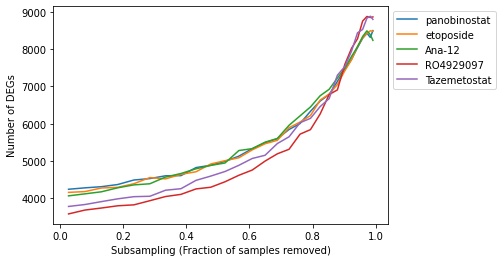

In [329]:
for i, x in enumerate(np.array(groups)[np.array(groups)!='control']):
    X = tensor[:, i]
    pl.plot(ratios, X, label=x)
pl.xlabel('Subsampling (Fraction of samples removed)')
pl.ylabel('Number of DEGs')
# Put a legend to the right of the current axis
pl.legend(loc='center left', bbox_to_anchor=(1, 0.8))
# pl.yscale('log')
pl.show()

This makes no fucking sense. (tessa: it does make sense).
Still DE testing as a metric is too confusing and unreliable.